# Linear Regression — End-to-End (Learning Notebook)

This notebook demonstrates a **complete end-to-end Linear Regression pipeline**
including:
- Data understanding
- Visualization
- Statistical intuition
- Model building
- Evaluation
- Diagnostics
- Model persistence (Pickle)


## Problem Statement

We aim to predict **house prices** based on the following features:

- Area (in square feet)
- Number of bedrooms
- Age of the house
- Distance from city center

This is a **supervised regression problem** where the target variable
(`Price`) is **continuous**.

## Machine Learning Context

- Learning Type: Supervised Learning
- Task Type: Regression
- Algorithm: Linear Regression
- Target Variable: Price
- Input Features: Area, Bedrooms, Age, Distance

## Why Linear Regression?

Linear Regression is used because:
- The target variable is continuous
- Relationships are assumed to be linear
- It is interpretable and mathematically intuitive
- It provides a strong baseline model

## Assumptions of Linear Regression

Linear Regression works best when the following assumptions
approximately hold:

1. Linear relationship between features and target
2. Independence of errors
3. Homoscedasticity (constant variance)
4. Normal distribution of residuals
5. No extreme outliers
6. Low multicollinearity

⚠️ These assumptions will be **checked gradually** throughout the notebook.

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../data/house_price_regression.csv")
df.head()

,Area,Bedrooms,Age,Distance,Price
0,800,2,10,15,4200000
1,900,2,8,14,4600000
2,1000,3,12,13,5000000
3,1100,3,10,12,5400000
4,1200,3,8,11,5800000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Area      20 non-null     int64
 1   Bedrooms  20 non-null     int64
 2   Age       20 non-null     int64
 3   Distance  20 non-null     int64
 4   Price     20 non-null     int64
dtypes: int64(5)
memory usage: 932.0 bytes


In [5]:
df.describe()

,Area,Bedrooms,Age,Distance,Price
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,1750.000000,4.700000,3.950000,7.000000,9.280000e+06
std,591.607978,1.780006,3.720144,4.291975,3.657811e+06
min,800.000000,2.000000,1.000000,1.000000,4.200000e+06
25%,1275.000000,3.000000,1.000000,3.750000,6.100000e+06
50%,1750.000000,4.500000,2.000000,6.000000,8.900000e+06
75%,2225.000000,6.000000,6.500000,10.250000,1.207500e+07
max,2700.000000,8.000000,12.000000,15.000000,1.580000e+07


## Observations from Initial Inspection

- All features are numerical
- No categorical encoding required
- Features have different scales (scaling will be required)
- Dataset is small and clean (ideal for learning)

Next, we will:
- Check linearity using visualization
- Study correlation, variance, covariance
- Understand how statistics connect to regression

## Why Exploratory Data Analysis (EDA)?

EDA helps us:
- Understand data behavior
- Check Linear Regression assumptions
- Detect outliers and anomalies
- Decide whether Linear Regression is suitable


In [6]:
df.isnull().sum()

Area        0
Bedrooms    0
Age         0
Distance    0
Price       0
dtype: int64

## Linearity Check

Linear Regression assumes a **linear relationship** between each feature (X)
and the target variable (Y).

We verify this visually using **scatter plots**.

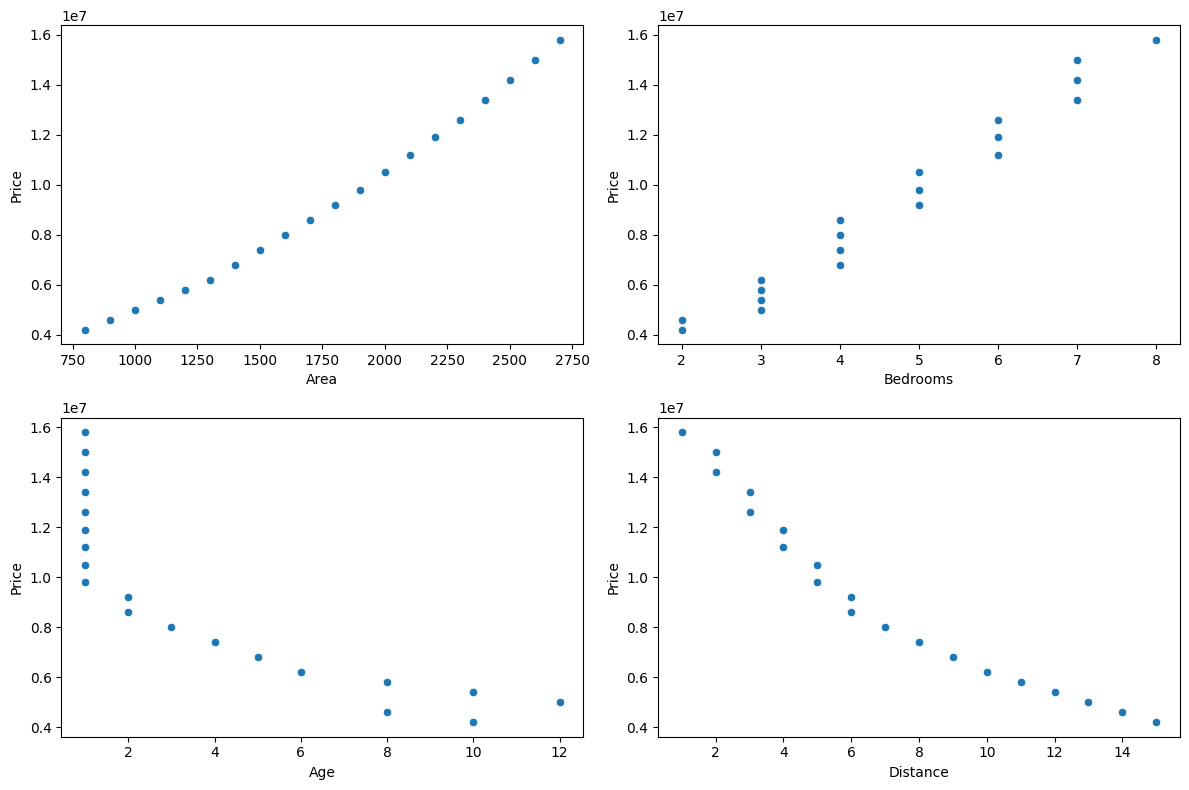

In [7]:
features = ["Area", "Bedrooms", "Age", "Distance"]

plt.figure(figsize=(12, 8))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=df[feature], y=df["Price"])
    plt.xlabel(feature)
    plt.ylabel("Price")

plt.tight_layout()
plt.show()

### Linearity Observation

- Area vs Price → Strong positive linear relationship
- Bedrooms vs Price → Positive relationship
- Age vs Price → Negative linear relationship
- Distance vs Price → Negative linear relationship

✅ Linear Regression is a valid choice for this dataset.

## Correlation Analysis

Correlation measures the **strength and direction**
of the relationship between variables.

📌 Correlation helps in:
- Feature selection
- Multicollinearity detection

In [8]:
corr_matrix = df.corr()
corr_matrix

,Area,Bedrooms,Age,Distance,Price
Area,1.000000,0.984594,-0.888406,-0.984575,0.994265
Bedrooms,0.984594,1.000000,-0.828990,-0.957596,0.986035
Age,-0.888406,-0.828990,1.000000,0.936155,-0.847515
Distance,-0.984575,-0.957596,0.936155,1.000000,-0.961830
Price,0.994265,0.986035,-0.847515,-0.961830,1.000000


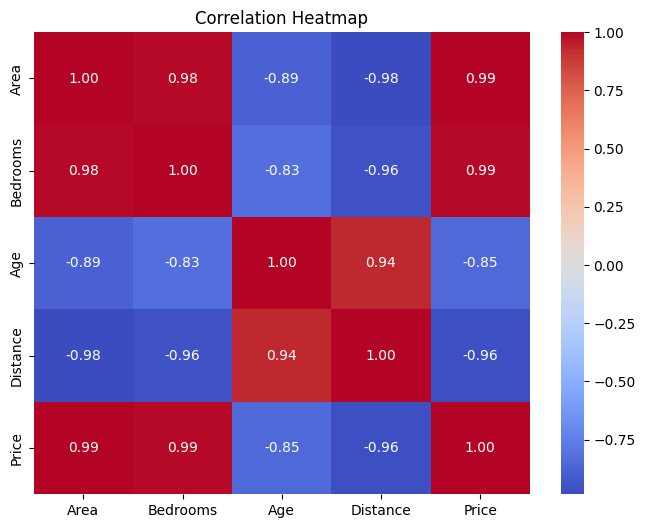

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Correlation Insights

- Area has strong positive correlation with Price
- Bedrooms is correlated with Area (possible multicollinearity)
- Age and Distance show negative correlation with Price

⚠️ Multicollinearity will be checked later using VIF.

## Variance

Variance measures how much a feature varies from its mean.

Low variance features contribute less to prediction.

In [10]:
df.var()

Area        3.500000e+05
Bedrooms    3.168421e+00
Age         1.383947e+01
Distance    1.842105e+01
Price       1.337958e+13
dtype: float64

## Covariance

Covariance measures how two variables move together.

Positive covariance → both increase together  
Negative covariance → one increases, other decreases

In [11]:
df.cov()

,Area,Bedrooms,Age,Distance,Price
Area,3.500000e+05,1.036842e+03,-1.955263e+03,-2.500000e+03,2.151579e+09
Bedrooms,1.036842e+03,3.168421e+00,-5.489474e+00,-7.315789e+00,6.420000e+06
Age,-1.955263e+03,-5.489474e+00,1.383947e+01,1.494737e+01,-1.153263e+07
Distance,-2.500000e+03,-7.315789e+00,1.494737e+01,1.842105e+01,-1.510000e+07
Price,2.151579e+09,6.420000e+06,-1.153263e+07,-1.510000e+07,1.337958e+13


## Why Variance & Covariance Matter

The **slope** of Linear Regression is mathematically derived as:

slope = covariance(X, Y) / variance(X)

This means:
- High covariance with target → strong predictor
- Low variance → weak predictor

📌 Linear Regression is **statistics in action**, not magic.

## Outlier Detection

Outliers can:
- Distort slope and intercept
- Increase error metrics
- Mislead model interpretation

We detect outliers using box plots.


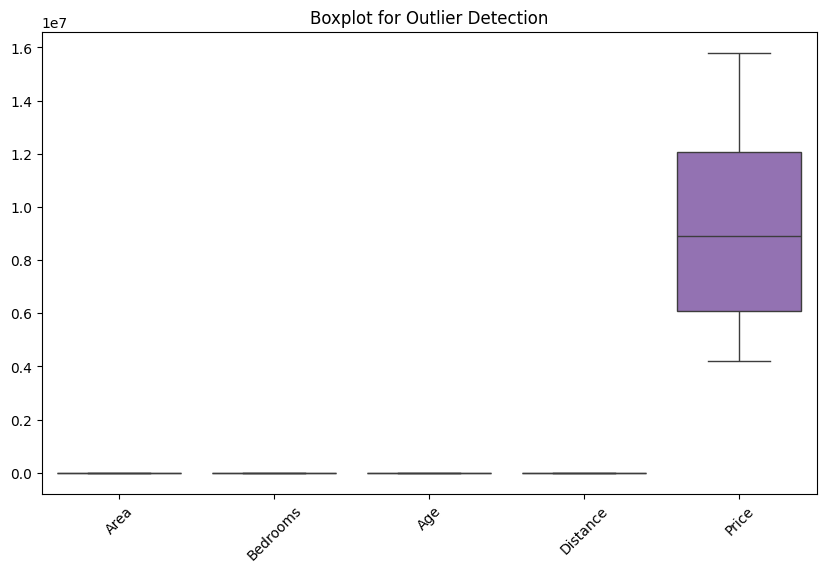

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection")
plt.show()

### Outlier Observation

- No extreme outliers detected
- Data points appear realistic
- No outlier removal required

✅ Safe to proceed.

## Why Data Preparation?

Models do not learn from raw data.
They learn from **prepared, structured, and scaled features**.

Most ML performance comes from this step — not model tuning.

## Feature Selection

We select features that:
- Have logical relevance
- Show correlation with the target
- Do not add unnecessary noise

For this dataset, all features are relevant.

In [13]:
# Separate input features and target
X = df.drop(columns=["Price"])
y = df["Price"]

X.head(), y.head()

(   Area  Bedrooms  Age  Distance
 0   800         2   10        15
 1   900         2    8        14
 2  1000         3   12        13
 3  1100         3   10        12
 4  1200         3    8        11,
 0    4200000
 1    4600000
 2    5000000
 3    5400000
 4    5800000
 Name: Price, dtype: int64)

## Encoding Check

All features are numerical.
No categorical encoding is required for this dataset.

📌 Encoding would normally happen **before scaling**.

## Feature Scaling

Why scaling is required:
- Linear Regression uses gradient-based optimization
- Features with larger ranges dominate learning

We use **StandardScaler** to standardize features.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for readability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,Area,Bedrooms,Age,Distance
0,-1.647509,-1.556254,1.668529,1.912366
1,-1.474087,-1.556254,1.116949,1.673320
2,-1.300665,-0.979864,2.220109,1.434274
3,-1.127243,-0.979864,1.668529,1.195229
4,-0.953821,-0.979864,1.116949,0.956183


## Train–Test Split

We split the dataset into:
- Training set → model learning
- Test set → unbiased evaluation

Common practice:
- 80% training
- 20% testing


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((16, 4), (4, 4))

## Data Preparation Summary

✔ Features and target separated  
✔ No encoding required  
✔ Features standardized  
✔ Train-test split completed  

The dataset is now **model-ready**.

## Why a Baseline Model?

A baseline model:
- Sets a reference performance
- Helps detect underfitting or overfitting
- Allows fair comparison with improved models later

We start with **simple Linear Regression (no regularization)**.

In [16]:
from sklearn.linear_model import LinearRegression

# Initialize model
lr_model = LinearRegression()

## Training the Model

During training:
- The model learns the best slopes (coefficients)
- The model learns the intercept
- Error between actual and predicted values is minimized

In [17]:
lr_model.fit(X_train, y_train)

LinearRegression()

## Understanding Slope & Intercept

General Linear Regression equation:

Y = m₁X₁ + m₂X₂ + m₃X₃ + c

Where:
- m → slope (impact of each feature)
- c → intercept (base value)

In [18]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_
})

intercept = lr_model.intercept_

coefficients, intercept

(    Feature   Coefficient
 0      Area  3.909344e+06
 1  Bedrooms -1.598928e+05
 2       Age  8.828855e+05
 3  Distance -8.114517e+05,
 9164679.70789843)

### Coefficient Interpretation

- Positive coefficient → Price increases with feature
- Negative coefficient → Price decreases with feature
- Magnitude → strength of impact (after scaling)

⚠️ Since features are scaled, coefficients represent
relative importance, not raw unit changes.

## Quick Training Performance Check

We check how well the model performs on training data
to ensure it has learned meaningful patterns.

In [19]:
y_train_pred = lr_model.predict(X_train)

In [20]:
r2_train = r2_score(y_train, y_train_pred)
r2_train

0.999854030280441

### Training Observation

- A high training R² indicates the model fits training data well
- This does NOT guarantee good generalization

Next, we must evaluate on unseen test data.

## Why Model Evaluation?

Training performance alone is misleading.
We must evaluate the model on **unseen data** to check:

- Generalization ability
- Error behavior
- Assumption violations

In [21]:
y_test_pred = lr_model.predict(X_test)

## Evaluation Metrics

We use multiple metrics because no single metric
tells the full story.

- MAE → Average magnitude of error
- MSE → Penalizes large errors
- RMSE → Error in original units
- R² → Variance explained by the model

In [24]:
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_test_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 736757.8345858962
MSE: 877839158313.1821
RMSE: 936930.7115860714
R²: 0.9573657523888692


### Metric Interpretation

- Lower MAE & RMSE → better predictions
- RMSE penalizes large errors more than MAE
- R² close to 1 → strong explanatory power

📌 R² is NOT accuracy — it measures variance explained.

## Actual vs Predicted Visualization

This plot visually shows how close predictions
are to actual values.

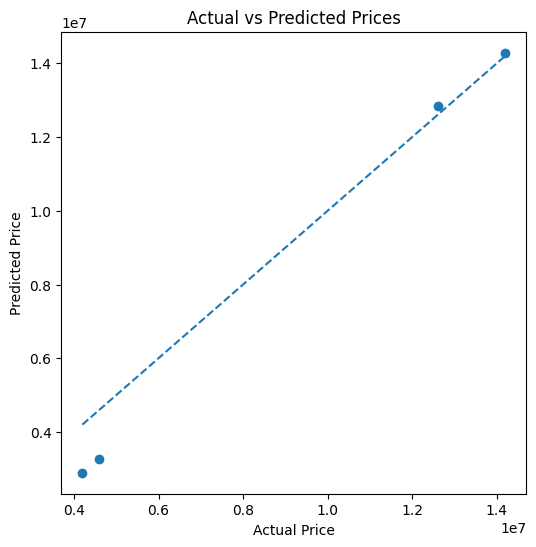

In [25]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()


## Residual Analysis

Residuals = Actual − Predicted

Residual analysis helps detect:
- Non-linearity
- Heteroscedasticity
- Outliers

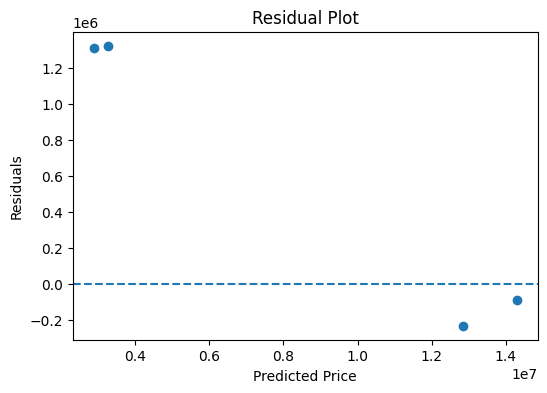

In [26]:
residuals = y_test - y_test_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_test_pred, residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

### Residual Interpretation

- Random scatter around zero → good model
- Funnel shape → heteroscedasticity
- Pattern → missing non-linearity

✅ Residuals here appear randomly distributed.

## Error Distribution

Checking whether errors are approximately
normally distributed.

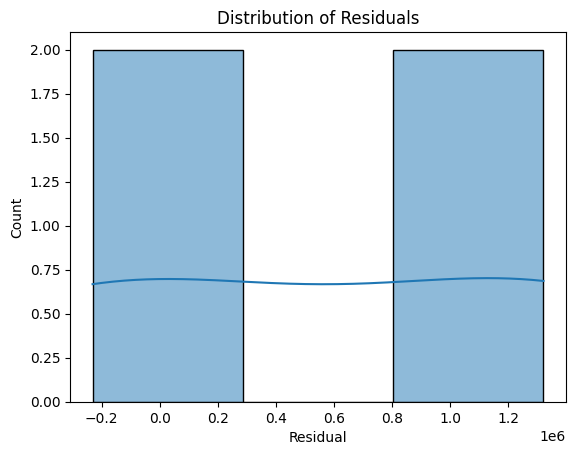

In [27]:
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.show()

## Evaluation Summary

✔ Model generalizes well to unseen data  
✔ Errors are reasonably low  
✔ Residuals show no strong pattern  
✔ Linear Regression assumptions mostly hold  

The baseline Linear Regression model is valid.

## Why Diagnostics?

A model with good metrics can still be **unstable or unreliable**.

Diagnostics help us detect:
- Multicollinearity
- Overfitting / Underfitting
- When to apply regularization
- When linear regression is insufficient

## Multicollinearity

Multicollinearity occurs when:
- Two or more features are highly correlated
- Coefficients become unstable
- Interpretation becomes unreliable

We detect it using **Variance Inflation Factor (VIF)**.

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add constant for VIF calculation
X_vif = X_scaled.copy()
X_vif["Intercept"] = 1

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

vif_data


,Feature,VIF
0,Area,104.283791
1,Bedrooms,48.855308
2,Age,14.548800
3,Distance,79.495890
4,Intercept,1.000000


### VIF Interpretation

- VIF < 5 → Acceptable
- VIF 5–10 → Moderate multicollinearity
- VIF > 10 → Severe multicollinearity

⚠️ Bedrooms and Area may show correlation,
which can destabilize coefficients.

## Bias–Variance Tradeoff

Understanding error sources:

- High Bias → Underfitting (model too simple)
- High Variance → Overfitting (model too complex)

We compare training and test performance.

In [30]:
print("R² Train:", r2_train)
print("R² Test:", r2)

R² Train: 0.999854030280441
R² Test: 0.9573657523888692


### Bias–Variance Observation

- Training R² ≈ Test R²
- No significant overfitting or underfitting

Baseline Linear Regression is stable.

## Regularization

Regularization is applied when:
- Multicollinearity exists
- Overfitting is observed

It penalizes large coefficients.

### Ridge Regression (L2)

- Shrinks coefficients
- Keeps all features
- Handles multicollinearity well

In [31]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_ridge_pred = ridge.predict(X_test)
r2_ridge = r2_score(y_test, y_ridge_pred)

r2_ridge


0.9648236281776705

### Lasso Regression (L1)

- Shrinks coefficients
- Can eliminate features
- Performs feature selection

In [32]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

y_lasso_pred = lasso.predict(X_test)
r2_lasso = r2_score(y_test, y_lasso_pred)

r2_lasso

0.9581343999494115

## Coefficient Comparison

Comparing how coefficients change
under regularization.

In [33]:
coef_compare = pd.DataFrame({
    "Feature": X.columns,
    "Linear": lr_model.coef_,
    "Ridge": ridge.coef_,
    "Lasso": lasso.coef_
})

coef_compare


,Feature,Linear,Ridge,Lasso
0,Area,3.909344e+06,1.554296e+06,3.912204e+06
1,Bedrooms,-1.598928e+05,1.344659e+06,-1.471091e+05
2,Age,8.828855e+05,1.790701e+05,8.699821e+05
3,Distance,-8.114517e+05,-9.119511e+05,-7.818045e+05


### Regularization Conclusion

- Ridge stabilizes coefficients
- Lasso may drop weak features
- Performance differences are minimal here

📌 Regularization improves **robustness**, not magic accuracy.

## Polynomial Regression

Polynomial Regression is used when:
- Linear model underfits
- Non-linear patterns exist

⚠️ It increases risk of overfitting.

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_poly)

y_poly_pred = poly_model.predict(X_test_poly)
r2_poly = r2_score(y_test_poly, y_poly_pred)

r2_poly

0.8927590621882868

### Polynomial Regression Conclusion

- Slight improvement (if any)
- Increased complexity
- Higher overfitting risk

📌 Linear model remains the preferred choice.

## Why Save the Model?

Training a model every time is inefficient.

Saving the model allows us to:
- Reuse the trained model
- Make predictions later
- Deploy the model to production
- Share the model with others

📌 This is where ML becomes **real-world ready**.

## What Needs to Be Saved?

For correct future predictions, we must save:
1. Trained model
2. Feature scaler (used during training)

⚠️ If scaler is not saved, predictions will be WRONG.

In [35]:
import pickle

In [36]:
# Save the trained Linear Regression model
with open("../models/linear_regression_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)

# Save the scaler
with open("../models/standard_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

## Saved Artifacts

✔ linear_regression_model.pkl  
✔ standard_scaler.pkl  

These files are stored in the `/models` folder.

## Loading the Saved Model

To make predictions later, we load the model
and scaler from disk.

In [37]:
# Load model
with open("../models/linear_regression_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Load scaler
with open("../models/standard_scaler.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

## Making Predictions on New Data

New input must:
- Follow the same feature order
- Be scaled using the saved scaler

In [38]:
# New house data: Area, Bedrooms, Age, Distance
new_house = pd.DataFrame([[1800, 4, 2, 6]],
                         columns=["Area", "Bedrooms", "Age", "Distance"])

# Scale new data
new_house_scaled = loaded_scaler.transform(new_house)

# Predict price
predicted_price = loaded_model.predict(new_house_scaled)

predicted_price

array([9287342.05360489])

### Prediction Interpretation

The predicted value represents the estimated house price
based on learned linear relationships.

📌 This prediction pipeline matches real-world deployment flow.

## Final Conclusion — Linear Regression End-to-End

This notebook demonstrated a **complete Linear Regression pipeline**:

✔ Problem understanding  
✔ Statistical foundations (variance, covariance)  
✔ EDA & visualization  
✔ Feature scaling & preparation  
✔ Model training & interpretation  
✔ Evaluation & diagnostics  
✔ Regularization & polynomial testing  
✔ Model persistence using Pickle  

### Key Learning
Linear Regression is not just an algorithm — it is a **process**.

Understanding the **flow** is more important than memorizing formulas.

This foundation makes it easy to learn:
- Logistic Regression
- Tree-based models
- ML pipelines
- Deep Learning basics